In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
import torch.nn.utils.prune as prune
from tqdm import tqdm
import copy

import config
from graph_models import FullGraphModel
from data_processing import DataProcessor
from utils import (
    get_image_paths, initialize_results_df, get_iteration_number,
    select_random_images, clean_model_outputs, update_results_df, update_running_loss
)
from plots import guess_your_plots, plot_results

device_type = "cpu"
device = torch.device(device_type)
dtype = torch.float32
cmap = plt.cm.binary

batch_size = config.batch_size

In [2]:
data_processor = DataProcessor(config)
model = FullGraphModel(data_processor, config).to(device)
criterion = CrossEntropyLoss()

In [3]:
def correct_test_results(test_results):
    # There was a bug in how we get the classes, and the 0-1 labels can be flipped
    # This function corrects the labels if the accuracy is below 0.5
    flipped = False
    if test_results["Is correct"].sum() / len(test_results) < 0.5:
        test_results["Is correct"] = np.abs(test_results["Is correct"] - 1)
        flipped = True

    return test_results, flipped

# test
def test(model):
    testing_images = get_image_paths(config.TESTING_DATA_DIR, config.small_length)
    already_selected_testing = []
    total_correct, total, running_loss = 0, 0, 0.0
    test_results = initialize_results_df()

    model.eval()
    iterations = get_iteration_number(len(testing_images), config)
    with torch.no_grad():
        for _ in tqdm(range(iterations)):
            batch_files, already_selected_testing = select_random_images(
                testing_images, batch_size, already_selected_testing
            )
            images, labels = data_processor.get_data_from_paths(batch_files)
            inputs, labels = data_processor.process_batch(images, labels)
            inputs = inputs.to(config.DEVICE)
            labels = labels.to(config.DEVICE)

            out = model(inputs)
            loss = criterion(out, labels)

            outputs, predictions, labels_cpu, correct = clean_model_outputs(out, labels)
            test_results = update_results_df(
                test_results, batch_files, outputs, predictions, labels_cpu, correct
            )
            running_loss += update_running_loss(loss, inputs)
            total += batch_size
            total_correct += correct.sum()

    test_results, flipped = correct_test_results(test_results)
    plot_types = guess_your_plots(config)
    final_plots = plot_results(
        test_results, plot_types=plot_types, classes=config.CLASSES
    )

    print(
        f"Finished testing with loss {running_loss / total} and "
        f"accuracy {total_correct / total}."
    )

    return test_results, final_plots, total_correct / total, flipped

In [4]:
# non random: "m_2025-02-01 07:43_eo3d2g2c.pth"

checkpoint = torch.load(
    "models/m_2025-02-04 09:29_gz6c68e6.pth",
    map_location=device_type,
)
model.load_state_dict(checkpoint["model"])
torch.set_grad_enabled(False)
model.eval()
model_orig = copy.deepcopy(model)

/tmp/ipykernel_6260/3341324676.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


In [5]:
results = {}
for ix, p in enumerate(np.linspace(0, 1, 11)):
    model = copy.deepcopy(model_orig)
    prune.random_unstructured(
        model.connectome, name="edge_weight_multiplier", amount=p
    )
    test_results, final_plots, accuracy, flipped = test(model)
    results[f"prune_{ix}"] = {
        "prune_frac": p,
        "test_results": test_results,
        "final_plots": final_plots,
        "accuracy": accuracy,
        "flipped": flipped,
    }

100%|██████████| 1250/1250 [2:15:36<00:00,  6.51s/it] 


Finished testing with loss 80524.95785547941 and accuracy 0.6782.


100%|██████████| 1250/1250 [2:13:21<00:00,  6.40s/it] 


Finished testing with loss 98513.61764750844 and accuracy 0.6594.


100%|██████████| 1250/1250 [2:14:07<00:00,  6.44s/it] 


Finished testing with loss 125348.53099614113 and accuracy 0.5761.


100%|██████████| 1250/1250 [2:12:42<00:00,  6.37s/it] 


Finished testing with loss 129284.61262359835 and accuracy 0.5847.


100%|██████████| 1250/1250 [2:13:04<00:00,  6.39s/it] 


Finished testing with loss 140442.8452310112 and accuracy 0.545.


100%|██████████| 1250/1250 [2:13:36<00:00,  6.41s/it] 


Finished testing with loss 137903.23039792618 and accuracy 0.5472.


100%|██████████| 1250/1250 [2:13:45<00:00,  6.42s/it] 
/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


Finished testing with loss 144410.42436606367 and accuracy 0.5282.


100%|██████████| 1250/1250 [2:14:04<00:00,  6.44s/it] 


Finished testing with loss 149874.13325837956 and accuracy 0.4976.


100%|██████████| 1250/1250 [2:14:38<00:00,  6.46s/it] 


Finished testing with loss 153997.18408333274 and accuracy 0.4814.


100%|██████████| 1250/1250 [2:14:36<00:00,  6.46s/it] 


Finished testing with loss 162008.27433543178 and accuracy 0.5049.


100%|██████████| 1250/1250 [2:13:57<00:00,  6.43s/it] 


Finished testing with loss nan and accuracy 0.5.


In [6]:
import pandas as pd
pa = pd.DataFrame({"prune_frac": [r["prune_frac"] for r in results.values()], "accuracy": [r["accuracy"] for r in results.values()]})

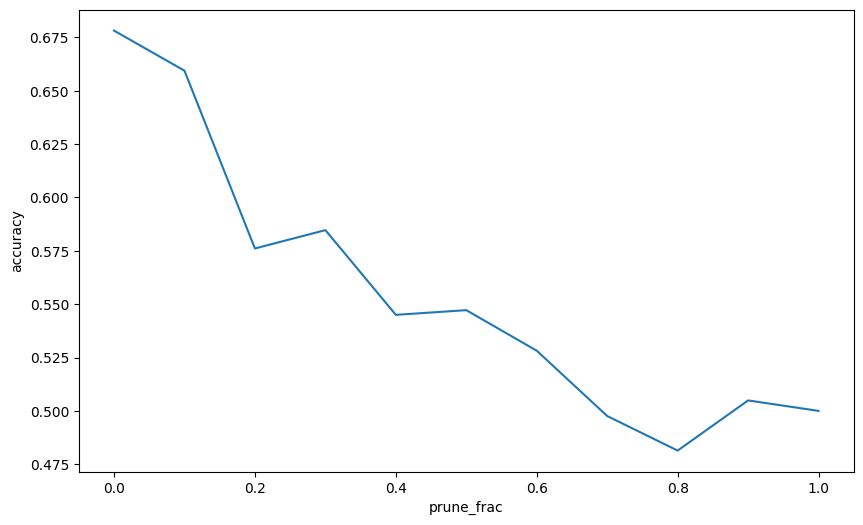

In [8]:
%matplotlib inline
import seaborn as sns

fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=pa, x="prune_frac", y="accuracy")
plt.show()

In [9]:
pa.to_csv("supplementary_data/prune_random_ture.csv", index=False)

In [1]:
import pandas as pd

normal = pd.read_csv("supplementary_data/prune_random_false.csv")
random = pd.read_csv("supplementary_data/prune_random_ture.csv")

In [3]:
# add a column to each
normal["type"] = "normal"
random["type"] = "random"
# put them together
both = pd.concat([normal, random])

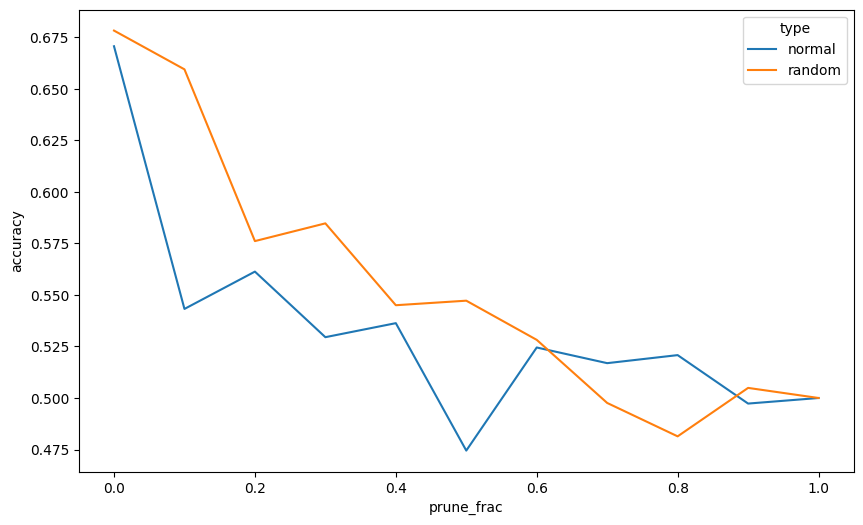

In [6]:
# plot both lines
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=both, x="prune_frac", y="accuracy", hue="type")
fig.savefig("supplementary_data/prune_random_or_not.png")